In [362]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, HuberRegressor, RANSACRegressor
from sklearn.metrics import classification_report   
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [363]:
## LOAD AND COMBINE FULL DATA ON EOG READINGS AND SACCADE LABELS

def load_data(EOG_filepath, label_filepath):
    EOG = pd.read_csv(EOG_filepath)
    labels = pd.read_csv(label_filepath)
    data = pd.concat([EOG, labels], axis=1)
    data = data.rename({'Var1': 'saccade_type'}, axis = 1)
    data = data.drop(0).reset_index(drop=True)
    data = data.drop(data.shape[0]-1).reset_index(drop=True)

    return data

In [364]:
#SEGMENT DATA INTO RESPECTIVE SACCADES AND BLINKS
def segment_data(data):
    data['group'] = (data['saccade_type'] != data['saccade_type'].shift()).cumsum()

    # split into a list of DataFrames
    segments = [g.drop(columns='group').reset_index(drop=True)
                for _, g in data.groupby('group')]
    return segments

SINCE the FORWARD SACCADES ARE THE ONLY ONES THAT CONTAIN INITIAL MOVEMENT FROM THE REFERENCE POINT of the CENTER OF THE SCREEN, THEY ARE THE ONLY ONES WE CARE ABOUT FOR COORDINATE MAPPING. THE RETURN SACCADES ARE DEPENDENT ON THE FORWARD SACCADES AND ARE REDUNDANT


In [365]:
#SELECT ONLY FORWARD SACCADES
def get_fw_saccades(segments):
    fw_saccades = [seg for seg in segments if seg['saccade_type'].iloc[0] == 1]
    return fw_saccades

In [366]:
#SELECT ONLY BACKWARD SACCADES
def get_bw_saccades(segments):
    bw_saccades = [seg for seg in segments if seg['saccade_type'].iloc[0] == 2]
    return bw_saccades


In [367]:
#IMPORT GAZE LABELS FOR EOG DATA
def load_gaze(gaze_filepath):
    gaze = pd.read_csv(gaze_filepath)
    gaze = gaze.rename({'TargetGA_1': 'angle_horiz', 'TargetGA_2': 'angle_vert'}, axis=1)
    gaze = gaze[gaze['angle_horiz'] != 0].reset_index(drop=True)
    return gaze

In [368]:
## GAZE TO COORDINATES
def gaze_to_coordinates(gaze_subj, distance):
    angle_horiz = gaze_subj['angle_horiz']
    angle_vert = gaze_subj['angle_vert']
    x = distance * np.tan((np.radians(angle_horiz)))
    y = distance * np.tan((np.radians(angle_vert)))
    return x, y

p1_coords = pd.DataFrame()
p1_coords['x'], p1_coords['y'] = gaze_to_coordinates(gaze_p1, 60)
p1_coords

,x,y
0,-3.992071,-1.086885
1,21.212588,-14.063831
2,14.909656,11.957373
3,23.445251,1.624888
4,7.946550,11.150135
...,...,...
295,9.024713,3.497681
296,-14.919332,-10.691895
297,-9.281068,-8.074654
298,-18.684515,0.993434


In [369]:
#MAP EOG READINGS TO GAZE ANGLES
def map_fw_saccades_to_coords(fw_saccades, coords):
    fw_mapping = {
        i: {'segment': seg, 
            'x': coords.loc[i, 'x'], 
            'y': coords.loc[i, 'y']}
        for i, seg in enumerate(fw_saccades)
    }
    return fw_mapping

def map_bw_saccades_to_coords(bw_saccades):
    bw_mapping = {
        i: {'segment': seg, 
            'x': 0, 
            'y': 0}
        for i, seg in enumerate(bw_saccades)
    }
    return bw_mapping


## BASELINE NORMALIZATION

Baseline normalization necessary so that all EOG readings start near zero. Accounting for baseline differences between forward saccades. Because we are only concerned with patterns and shapes of the EOG curves during different forward saccades we must make sure the values start at the same number. Example: perhaps a users EOG is raised over time at the center point due to fatigue or consecutive saccades, where it really should be the same every time (independent of the # trials)

In [370]:
import matplotlib.pyplot as plt

# Pick a segment to visualize (e.g., the first one)
#FORWARDS
def plot_baseline_norm(mapping, saccade_num):
    entry = list(mapping.values())[saccade_num]
    horiz = entry['segment']['Horizontal'].values.astype('float32')
    vert  = entry['segment']['Vertical'].values.astype('float32')

    # Baseline subtraction using first 10 samples (pre-saccade fixation)
    pre_samples = 10
    horiz_baseline = horiz - horiz[:pre_samples].mean()
    vert_baseline  = vert  - vert[:pre_samples].mean()

    # Plot
    plt.figure(figsize=(12,6))

    plt.subplot(2,1,1)
    plt.plot(horiz, label='Original Horizontal')
    plt.plot(horiz_baseline, label='Baseline-corrected Horizontal')
    plt.title('Horizontal EOG - Original vs Baseline Corrected, X: ' + str(entry['x']))
    plt.xlabel('Sample')
    plt.ylabel('EOG (µV)')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(vert, label='Original Vertical')
    plt.plot(vert_baseline, label='Baseline-corrected Vertical')
    plt.title('Vertical EOG - Original vs Baseline Corrected, Y: ' + str(entry['y']))
    plt.xlabel('Sample')
    plt.ylabel('EOG (µV)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [371]:
# def baseline_norm(mapping):
#         X_h_list = []
#         X_v_list = []
#         y_h_list = []
#         y_v_list = []
#         pre_samples = 10
#         for entry in mapping.values():
#                 horiz = entry['segment']['Horizontal'].values.astype('float32')
#                 vert  = entry['segment']['Vertical'].values.astype('float32')
                
#                 # Baseline normalization using first `pre_samples`
#                 baseline_h = horiz[:pre_samples].mean() if len(horiz) >= pre_samples else horiz.mean()
#                 baseline_v = vert[:pre_samples].mean()  if len(vert)  >= pre_samples else vert.mean()
#                 horiz -= baseline_h
#                 vert  -= baseline_v
                
#                 X_h_list.append(horiz)
#                 X_v_list.append(vert)
                
#                 # Target: one coordinate per segment
#                 y_h_list.append(entry['x'])
#                 y_v_list.append(entry['y'])
#         return X_h_list, X_v_list, y_h_list, y_v_list

# fw_X_h_list_p1, fw_X_v_list_p1, fw_y_h_list_p1, fw_y_v_list_p1 = baseline_norm(fw_mapping_p1)
# bw_X_h_list_p1, bw_X_v_list_p1, bw_y_h_list_p1, bw_y_v_list_p1 = baseline_norm(bw_mapping_p1)


# fw_X_h_list_p1 = pad_sequences(fw_X_h_list_p1, maxlen=256, dtype='float32', padding='post')
# bw_X_h_list_p1 = pad_sequences(bw_X_h_list_p1, maxlen=256, dtype='float32', padding='post')
# combined_X_h_saccades = []
# len(fw_X_h_list_p1)
# for index, value in enumerate(fw_X_h_list_p1):
#         combined_X_h_saccades.append(fw_X_h_list_p1[index] + bw_X_h_list_p1[index])

# plt.plot(combined_X_h_saccades[22])

## ANALYZE RELATIONSHIP BETWEEN DELTAEOG AND COORDS

In [372]:
def visualize_deltaEOG_Coords(fw_mapping):
    deltaEOG_h = []
    deltaEOG_v = []
    deltaX = []
    deltaY = []
    for entry in fw_mapping.values():
        horiz = entry['segment']['Horizontal'].values.astype('float32')
        vert  = entry['segment']['Vertical'].values.astype('float32')
        deltaEOG_h.append(horiz[-1] - horiz[0])
        deltaEOG_v.append(vert[-1]  - vert[0])
        deltaX.append(entry['x'] - 0)  # assuming starting angle is 0
        deltaY.append(entry['y'] - 0)  # assuming starting angle is 0

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(deltaX, deltaEOG_h)
    plt.xlabel('change in X Coordinate')
    plt.ylabel('Change in Horizontal EOG (µV)')
    plt.title('delta Horizontal EOG vs deltaX Coordinate (relative to origin) For Each Saccade')

    slope, intercept = np.polyfit(deltaX, deltaEOG_h, 1)
    plt.plot(deltaX, slope * np.array(deltaX) + intercept, color='red', label='Line of Best Fit')   
    plt.legend()


    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(deltaY, deltaEOG_v)
    plt.xlabel('change in Y Coordinate')
    plt.ylabel('Change in Vertical EOG (µV)')
    plt.title('delta Vertical EOG vs deltaY Coordinate (relative to origin) For Each Saccade')

    slope, intercept = np.polyfit(deltaY, deltaEOG_v, 1)
    plt.plot(deltaY, slope * np.array(deltaY) + intercept, color='red', label='Line of Best Fit')   
    plt.legend()

In [373]:
def preprocess_data(fw_mapping):
#PARAMETERS
    Fs = 256                 # sampling frequency
    max_len = Fs             # maximum samples per segment (~1 second)
    pre_samples = 10         # optional baseline window

    # SEGMENTS AND TARGET COORDINATES
    X_h_list = []
    X_v_list = []
    y_h_list = []
    y_v_list = []

    for entry in fw_mapping.values():
        horiz = entry['segment']['Horizontal'].values.astype('float32')
        vert  = entry['segment']['Vertical'].values.astype('float32')
        
        # Baseline normalization using first `pre_samples`
        baseline_h = horiz[:pre_samples].mean() if len(horiz) >= pre_samples else horiz.mean()
        baseline_v = vert[:pre_samples].mean()  if len(vert)  >= pre_samples else vert.mean()
        horiz -= baseline_h
        vert  -= baseline_v
        
        X_h_list.append(horiz)
        X_v_list.append(vert)
        
        # Target: one coordinate per segment
        y_h_list.append(entry['x'])
        y_v_list.append(entry['y'])

    # Pad sequences to max_len
    X_h = pad_sequences(X_h_list, maxlen=max_len, dtype='float32', padding='post')
    X_v = pad_sequences(X_v_list, maxlen=max_len, dtype='float32', padding='post')

    # Reshape for LSTM input: (samples, timesteps, features)
    X_h = X_h[..., np.newaxis]
    X_v = X_v[..., np.newaxis]

    y_h = np.array(y_h_list, dtype='float32')
    y_v = np.array(y_v_list, dtype='float32')
    #TRAIN TEST SPLIT
    num_segments = X_h.shape[0]
    indices = np.arange(num_segments)

    # 70% train, 15% val, 15% test
    train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

    # Horizontal data splits
    X_train_h, y_train_h = X_h[train_idx], y_h[train_idx]
    X_test_h,  y_test_h  = X_h[test_idx],  y_h[test_idx]

    # Vertical data splits
    X_train_v, y_train_v = X_v[train_idx], y_v[train_idx]
    X_test_v,  y_test_v  = X_v[test_idx],  y_v[test_idx]

    return X_train_h, y_train_h, X_test_h, y_test_h, X_train_v, y_train_v, X_test_v, y_test_v

X_train_h_p1, y_train_h_p1, X_test_h_p1, y_test_h_p1, X_train_v_p1, y_train_v_p1, X_test_v_p1, y_test_v_p1 = preprocess_data(fw_mapping_p1)

## LINEAR REGRESSION

In [403]:
def linear_regression_horizontal(X_train_h, y_train_h, X_test_h, y_test_h):
    linear_model_h = LinearRegression()
    linear_model_h.fit(X_train_h.reshape(X_train_h.shape[0], -1), y_train_h)
    linear_x_pred = linear_model_h.predict(X_test_h.reshape(X_test_h.shape[0], -1))
    print('-----------------------------------------------------')
    print("Horizontal Linear Regression:")
    print("R²:", r2_score(y_test_h, linear_x_pred))
    print("RMSE:", root_mean_squared_error(y_test_h, linear_x_pred))
    print('-----------------------------------------------------')


def linear_regression_vertical(X_train_v, y_train_v, X_test_v, y_test_v):
    linear_model_v = LinearRegression()
    linear_model_v.fit(X_train_v.reshape(X_train_v.shape[0], -1), y_train_v)
    linear_y_pred = linear_model_v.predict(X_test_v.reshape(X_test_v.shape[0], -1))
    print('-----------------------------------------------------')
    print("\nVertical Linear Regression:")
    print("R²:", r2_score(y_test_v, linear_y_pred))
    # residuals = y_test_v - linear_y_pred
    # largest_residual = max(abs(residuals))
    # print("Largest Residual:", largest_residual)
    print("RMSE:", root_mean_squared_error(y_test_v, linear_y_pred))
    print('-----------------------------------------------------')



def huber_regression_vertical(X_train_v, y_train_v, X_test_v, y_test_v):
    huber_model_v = HuberRegressor(epsilon=1, alpha = 0)
    huber_model_v.fit(X_train_v.reshape(X_train_v.shape[0], -1), y_train_v)
    huber_y_pred = huber_model_v.predict(X_test_v.reshape(X_test_v.shape[0], -1))
    print('-----------------------------------------------------')
    print("\nVertical Huber Regression:")
    print("R²:", r2_score(y_test_v, huber_y_pred))
    print("RMSE:", root_mean_squared_error(y_test_v, huber_y_pred))
    print('-----------------------------------------------------')

linear_regression_horizontal(X_train_h_p1, y_train_h_p1, X_test_h_p1, y_test_h_p1)
linear_regression_vertical(X_train_v_p1, y_train_v_p1, X_test_v_p1, y_test_v_p1)



-----------------------------------------------------
Horizontal Linear Regression:
R²: 0.9928358197212219
RMSE: 1.2015091180801392
-----------------------------------------------------
-----------------------------------------------------

Vertical Linear Regression:
R²: 0.9792423248291016
RMSE: 1.1667510271072388
-----------------------------------------------------


# BLINK VS SACCADE CLASSIFICATION

In [375]:
def get_blinks(segments):
    blinks = [seg for seg in segments if seg['saccade_type'].iloc[0] == 3]
    return blinks

def norm_blinks(blinks):
    blinks_norm = []
    for entry in blinks:
        blink_vert_norm = entry['Vertical'].values
        baseline_v_blinks = blink_vert_norm[0]
        blink_vert_norm -= baseline_v_blinks
        blinks_norm.append(blink_vert_norm)
    return blinks_norm

def plot_blink(blinks_norm, blinks_notnorm, num_blink):
    blink_entry = blinks_notnorm[num_blink]
    blink_vert  = blink_entry['Vertical'].values.astype('float32')

    plt.figure(figsize=(12,5))
    plt.plot(blink_vert, label='Original Vertical')
    plt.plot(blinks_norm[num_blink], label='Baseline-corrected Vertical')
    plt.title(f'Blink Segment {num_blink} - Original vs Baseline Corrected')
    plt.xlabel('Sample')
    plt.ylabel('EOG (µV)')
    plt.legend()
    plt.show()

In [376]:
def norm_saccades_vert(fw_saccades):
    saccades_norm = []
    pre_samples = 10
    for entry in fw_saccades:
        vert = entry['Vertical'].values.astype('float32')
        # Baseline normalization using first `pre_samples`
        baseline_v = vert[:pre_samples].mean()  if len(vert)  >= pre_samples else vert.mean()
        vert  -= baseline_v
        saccades_norm.append(vert)
    return saccades_norm

## CLASSIFY BLINKS BASED ON PEAK VALUES

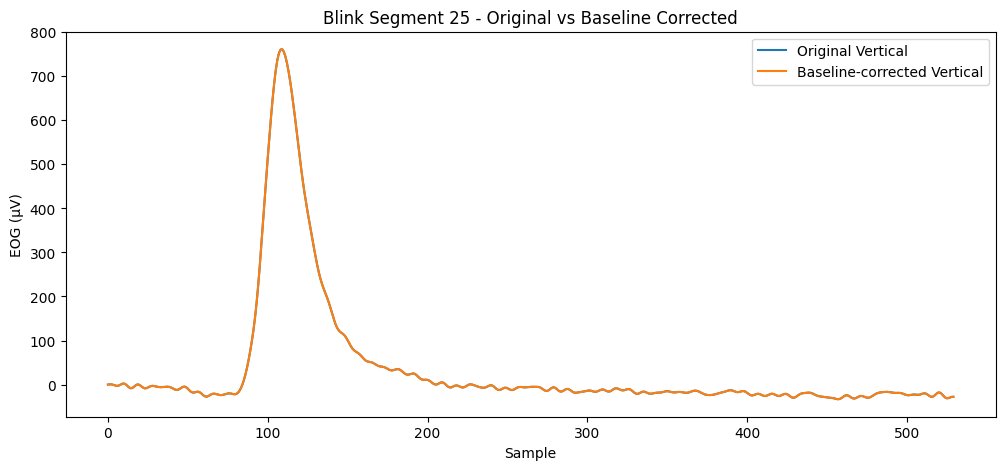

In [377]:
plot_blink(blinks_norm_p1, blinks_p1, 25)

In [378]:
# positive_slopes = []
# negative_slopes = []
# for saccade in saccades_norm_p1:
#     grad_saccade = np.gradient(saccade)
#     grad_smooth_saccade = np.convolve(grad_saccade, np.ones(5)/5, mode='same')
#     max_sacc_slope = max(grad_smooth_saccade)
#     min_sacc_slope = min(grad_smooth_saccade)

#     if max_sacc_slope > abs(min_sacc_slope):
#         positive_slopes.append(max_sacc_slope)
#     else: 
#         negative_slopes.append(min_sacc_slope)
# positive_slopes = [num for num in positive_slopes if num > 0]
# min(positive_slopes), max(positive_slopes)
# max(negative_slopes), min(negative_slopes)



In [379]:
#Function for getting the lowest possible blink peak given a few blinks in calibration
def blinkCalibration(blinks_norm):

    #Peak Thresholding
    peak_blinks_list = []
    for blink in blinks_norm:
        peak_blink = max(blink)
        min_blink = abs(min(blink))
        if peak_blink > min_blink:
            peak_blinks_list.append(peak_blink)

    peak_blinks_std = np.std(peak_blinks_list)
    peak_lowest = min(peak_blinks_list) - peak_blinks_std

    #Slope Thresholding
    rise_slopes = []
    fall_slopes = []
    for blink in blinks_norm: 
        grad = np.gradient(blink)
        grad_smooth = np.convolve(grad, np.ones(5)/5, mode='same')
        rise_slopes.append(max(grad_smooth))
        fall_slopes.append(min(grad_smooth))

    rise_slope_std = np.std(rise_slopes)
    fall_slope_std = np.std(fall_slopes)
    print(min(rise_slopes), max(rise_slopes))
    print(max(fall_slopes), min(fall_slopes))

    print('standard deviations for rise and fall slopes: ', rise_slope_std, fall_slope_std, 'mean', np.mean(rise_slopes), np.mean(fall_slopes), 'variance: ', np.var(rise_slopes), np.var(fall_slopes))
    min_rise_slope = min(rise_slopes) - rise_slope_std
    max_fall_slope = max(fall_slopes) + fall_slope_std

    return peak_lowest, min_rise_slope, max_fall_slope


#Function for classifying future blinks
def classifyblinkorsaccade(eye_movement, peak_lowest, min_rise_slope, max_fall_slope):
    # We need to tell if we have a whole blink signal within the window or only half one to
    # determine which classification method to use...
    # If your max value is in the at the first or last index, you do not have a complete peak, and your peak is cut in half or incomplete in the window either at the start or end.
    # If your max value is at the first index, your slope is negative , if your max value is at the last index, the slope is positive
    if np.argmax(eye_movement) == 0:
        if max(np.gradient(eye_movement)) > min_rise_slope:
            classification = 'blink'
        else:
            classification = 'saccade'

    elif np.argmax(eye_movement) == (len(eye_movement) - 1): 
        if min(np.gradient(eye_movement)) < max_fall_slope:
            classification = 'blink'
        else: 
            classification = 'saccade'
    else: 
        if eye_movement.max() > peak_lowest:
            classification = 'blink'
        elif eye_movement.max() < peak_lowest:
            classification = 'saccade'
    
    return classification

#Test the accuracy of the classification
def test_accuracy(blinks_norm, peak_lowest, min_rise_slope, max_fall_slope):
    blink_acc_list = [] 
    for blink in blinks_norm: 
        if classifyblinkorsaccade(blink, peak_lowest, min_rise_slope, max_fall_slope) == 'blink':
            blink_acc_list.append(1)
        else: 
            blink_acc_list.append(0)
    return np.mean(blink_acc_list)

-----------------------------------------------------
Horizontal Linear Regression:
R²: 0.9828590154647827
RMSE: 1.9856221675872803
-----------------------------------------------------
-----------------------------------------------------

Vertical Linear Regression:
R²: 0.8563793301582336
RMSE: 3.1783297061920166
-----------------------------------------------------
-----------------------------------------------------

Vertical Huber Regression:
R²: 0.8062322382898723
RMSE: 3.6917410461414297
-----------------------------------------------------
23.573657226562503 36.251562500000006
-11.183520507812501 -16.358984375000002
standard deviations for rise and fall slopes:  2.5916736595028746 1.4947126299623599 mean 31.130880126953127 -13.692724609375 variance:  6.716772357361023 2.2341658461689944
0.9714285714285714


/Users/joshuasu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


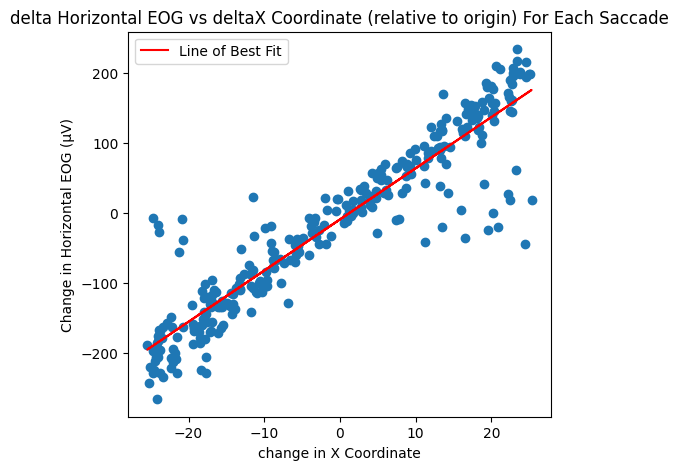

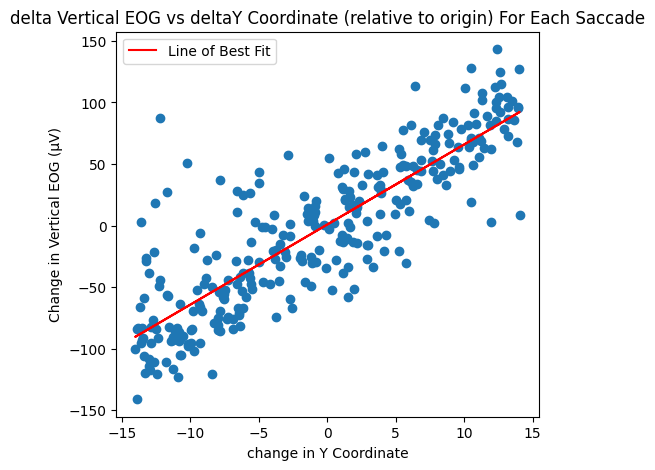

In [407]:
#Now let's test this code on a new subject: 
def run_on_new_subject(subject_num: int):
    data = load_data(f'./Malta_Data_P{subject_num}/p{subject_num}_EOG_transposed.csv', f'./Malta_Data_P{subject_num}/p{subject_num}_ControlSignal_transposed.csv')
    segments = segment_data(data)
    fw_saccades = get_fw_saccades(segments)
    gaze = load_gaze(f'./Malta_Data_P{subject_num}/p{subject_num}_TargetGA.csv')
    coords = pd.DataFrame()
    coords['x'], coords['y'] = gaze_to_coordinates(gaze, 60)
    fw_mapping = map_fw_saccades_to_coords(fw_saccades, coords)
    visualize_deltaEOG_Coords(fw_mapping)
    X_train_h, y_train_h, X_test_h, y_test_h, X_train_v, y_train_v, X_test_v, y_test_v = preprocess_data(fw_mapping)
    linear_regression_horizontal(X_train_h, y_train_h, X_test_h, y_test_h)
    linear_regression_vertical(X_train_v, y_train_v, X_test_v, y_test_v)
    huber_regression_vertical(X_train_v, y_train_v, X_test_v, y_test_v)

    blinks = get_blinks(segments)
    blinks_norm = norm_blinks(blinks)
    # plot_blink(blinks_norm, blinks, 5)
    peak_lowest, min_rise_slope, max_fall_slope = blinkCalibration(blinks_norm[0:20])
    print(test_accuracy(blinks_norm[20:], peak_lowest, min_rise_slope, max_fall_slope))

#Edit this argument to switch between subject 1, 2, 3, etc. 
run_on_new_subject(4)